In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')



In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data', one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [15]:
n_pixels = 28 * 28

# Placeholders --> Gateways
X = tf.placeholder(tf.float32, shape = ([None, n_pixels]))

In [16]:
def weight_variables(shape, name):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name=name)

def bias_variables(shape, name):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name=name)

def FC_layer(X, w, b):
    return tf.matmul(X, w) + b



# Encoder 
- Latent_dimensionality ==> Hyperparameter --> The number of dimensions we want, we're doing hit and try for this.
- hidden_dimensionality ==> Number of neurons in input layers
- mu --> Mean

In [17]:
latent_dim = 20
h_dim = 500

# 2 layer feed froward eural network
# Layer 1:  
w_enc = weight_variables([n_pixels, h_dim], 'w_enc')  # Tensor
b_enc = bias_variables([h_dim], 'b_enc')  # Tensor
# tanh --> Activation funtion(range : (-1 to 1)), It avoids vanishing gradient problem
h_enc = tf.nn.tanh(FC_layer(X, w_enc, b_enc))

# Layer 2: 
w_mu = weight_variables([h_dim, latent_dim], 'w_mu')  # Tensor
b_mu = bias_variables([latent_dim], 'b_mu')  # Tensor
# tanh --> Activation funtion(range : (-1 to 1)), It avoids vanishing gradient problem
mu = FC_layer(h_enc, w_mu, b_mu) #mean


# Compute partial derivatives w.r.t our input values given our weight and bias
# Standard Deviation : 
w_logstd = weight_variables([h_dim, latent_dim], 'w_logstd')  # Tensor
b_logstd = bias_variables([latent_dim], 'b_logstd')  # Tensor
# tanh --> Activation funtion(range : (-1 to 1)), It avoids vanishing gradient problem
logstd = FC_layer(h_enc, w_logstd, b_logstd) #std


# Randomness:
noise = tf.random_normal([1, latent_dim])

# This is the ouput
z = mu + tf.multiply(noise, tf.exp(.5*logstd))


# Decoder

In [18]:
# decoder

#layer 1
W_dec = weight_variables([latent_dim, h_dim], 'W_dec')
b_dec = bias_variables([h_dim], 'b_dec')
#pass in z here (and the weights and biases we just defined)
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))


#layer 2, using the original n pixels here since thats the dimensiaonlty
#we want to restore our data to
W_reconstruct = weight_variables([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variables([n_pixels], 'b_reconstruct')
#784 bernoulli parameters output
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))


# Loss

In [19]:
#lets define our loss function

# variational lower bound

# add epsilon to log to prevent numerical overflow
#Information is lost because it goes from a smaller to a larger dimensionality. 
#How much information is lost? We measure this using the reconstruction log-likelihood 
#This measure tells us how effectively the decoder has learned to reconstruct
#an input image x given its latent representation z.
log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
#KL Divergence
#If the encoder outputs representations z that are different 
#than those from a standard normal distribution, it will receive 
#a penalty in the loss. This regularizer term means 
#‘keep the representations z of each digit sufficiently diverse’. 
#If we didn’t include the regularizer, the encoder could learn to cheat
#and give each datapoint a representation in a different region of Euclidean space. 
KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)

# This allows us to use stochastic gradient descent with respect to the variational parameters
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

# Training

In [20]:
#init all variables and start the session!
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
## Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [21]:
import time #lets clock training time..

num_iterations = 1000
recording_interval = 1000
#store value for these 3 terms so we can plot them later
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []

# type(num_iterations/recording_interval)
iteration_array = [i*recording_interval for i in range(int(num_iterations/recording_interval))]
for i in range(num_iterations):
    # np.round to make MNIST binary
    #get first batch (200 digits)
    x_batch = np.round(mnist.train.next_batch(200)[0])
    #run our optimizer on our data
    sess.run(optimizer, feed_dict={X: x_batch})
    if (i%recording_interval == 0):
        #every 1K iterations record these values
        vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
        print ("Iteration: {}, Loss: {}".format(i, vlb_eval))
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))

Iteration: 0, Loss: -947.5431518554688


In [22]:
len(iteration_array)

1

Text(0.5, 1.0, 'Loss per iteration')

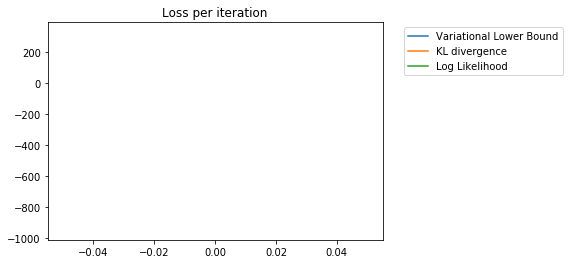

In [23]:
plt.figure()
#for the number of iterations we had 
#plot these 3 terms
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

In [ ]:
import os
load_model = False
if load_model:
    saver.restore(sess, os.path.join(os.getcwd(), "Trained Bernoulli VAE"))

num_pairs = 10
image_indices = np.random.randint(0, 200, num_pairs)
#Lets plot 10 digits
for pair in range(num_pairs):
    #reshaping to show original test image
    x = np.reshape(mnist.test.images[image_indices[pair]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (28,28))
    plt.subplot(121)
    plt.imshow(x_image)
    #reconstructed image, feed the test image to the decoder
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    #reshape it to 28x28 pixels
    x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
    #plot it!
    plt.subplot(122)
    plt.imshow(x_reconstruction_image)